# softmax回归的简洁实现
:label:`sec_softmax_concise`

在 :numref:`sec_linear_concise`中，
我们发现(**通过深度学习框架的高级API能够使实现**)
(~~softmax~~)
线性(**回归变得更加容易**)。
同样，通过深度学习框架的高级API也能更方便地实现softmax回归模型。
本节如在 :numref:`sec_softmax_scratch`中一样，
继续使用Fashion-MNIST数据集，并保持批量大小为256。


In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

如我们在 :numref:`sec_softmax`所述，
[**softmax回归的输出层是一个全连接层**]。
因此，为了实现我们的模型，
我们只需在`Sequential`中添加一个带有10个输出的全连接层。
同样，在这里`Sequential`并不是必要的，
但它是实现深度模型的基础。
我们仍然以均值0和标准差0.01随机初始化权重。


In [5]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
"""
在深度学习中，数据通常表示为多维张量，例如图像可以表示为三维张量（宽度、高度和通道）。
然而，在神经网络的输入层中，通常期望的输入是一维向量。

平展层（Flatten）是一种用于将多维张量转换为一维向量的操作。它将输入的多维张量展平成一个连续的一维向量，以便作为神经网络的输入。
在代码中，nn.Flatten()表示将输入的形状为（batch_size, width, height, channels）的张量展平成形状为
（batch_size, width * height * channels）的一维向量。

通过使用平展层，可以将具有多维结构的数据（例如图像）转换为适合输入神经网络的一维表示。
这允许我们使用全连接层等期望一维输入的层来处理数据。

在给定的代码中，nn.Sequential(nn.Flatten(), nn.Linear(784, 10))表示一个顺序的神经网络模型，
第一层是平展层，将输入的图像数据展平为一维向量，然后接着是一个线性层（全连接层），将一维向量映射到具有10个输出的向量，
用于分类任务中的类别预测。
"""
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

## 重新审视Softmax的实现
:label:`subsec_softmax-implementation-revisited`

在前面 :numref:`sec_softmax_scratch`的例子中，
我们计算了模型的输出，然后将此输出送入交叉熵损失。
从数学上讲，这是一件完全合理的事情。
然而，从计算角度来看，指数可能会造成数值稳定性问题。

回想一下，softmax函数$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，
其中$\hat y_j$是预测的概率分布。
$o_j$是未规范化的预测$\mathbf{o}$的第$j$个元素。
如果$o_k$中的一些数值非常大，
那么$\exp(o_k)$可能大于数据类型容许的最大数字，即*上溢*（overflow）。
这将使分母或分子变为`inf`（无穷大），
最后得到的是0、`inf`或`nan`（不是数字）的$\hat y_j$。
在这些情况下，我们无法得到一个明确定义的交叉熵值。

解决这个问题的一个技巧是：
在继续softmax计算之前，先从所有$o_k$中减去$\max(o_k)$。
这里可以看到每个$o_k$按常数进行的移动不会改变softmax的返回值：

$$
\begin{aligned}
\hat y_j & =  \frac{\exp(o_j - \max(o_k))\exp(\max(o_k))}{\sum_k \exp(o_k - \max(o_k))\exp(\max(o_k))} \\
& = \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}.
\end{aligned}
$$


在减法和规范化步骤之后，可能有些$o_j - \max(o_k)$具有较大的负值。
由于精度受限，$\exp(o_j - \max(o_k))$将有接近零的值，即*下溢*（underflow）。
这些值可能会四舍五入为零，使$\hat y_j$为零，
并且使得$\log(\hat y_j)$的值为`-inf`。
反向传播几步后，我们可能会发现自己面对一屏幕可怕的`nan`结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。
通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。
如下面的等式所示，我们避免计算$\exp(o_j - \max(o_k))$，
而可以直接使用$o_j - \max(o_k)$，因为$\log(\exp(\cdot))$被抵消了。

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}\right) \\
& = \log{(\exp(o_j - \max(o_k)))}-\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)} \\
& = o_j - \max(o_k) -\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)}.
\end{aligned}
$$

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。
但是，我们没有将softmax概率传递到损失函数中，
而是[**在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数**]，
这是一种类似["LogSumExp技巧"](https://en.wikipedia.org/wiki/LogSumExp)的聪明方式。


In [6]:
# nn.CrossEntropyLoss(reduction='none')是一个用于计算交叉熵损失的函数。交叉熵损失通常用于多类别分类问题。
# reduction='none'参数表示不对损失进行降维操作，即返回每个样本的损失值，而不是对所有样本的损失进行平均或求和。
loss = nn.CrossEntropyLoss(reduction='none')

## 优化算法

在这里，我们(**使用学习率为0.1的小批量随机梯度下降作为优化算法**)。
这与我们在线性回归例子中的相同，这说明了优化器的普适性。


In [7]:
# torch.optim.SGD(net.parameters(), lr=0.1)是使用随机梯度下降（SGD）优化算法对模型的参数进行优化的工具。
# 它接受一个参数迭代器（这里使用net.parameters()获取模型的参数），并设置学习率为0.1。
# SGD是一种常用的优化算法，用于在训练过程中更新模型参数以最小化损失函数。
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 训练

接下来我们[**调用**] :numref:`sec_softmax_scratch`中(~~之前~~)
(**定义的训练函数来训练模型**)。


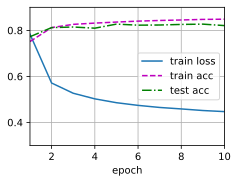

In [6]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

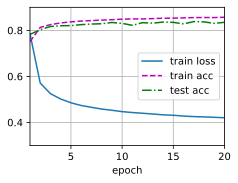

In [8]:
num_epochs = 20
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


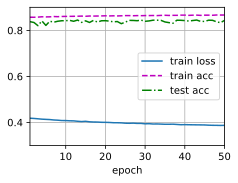

In [9]:
num_epochs = 50
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


和以前一样，这个算法使结果收敛到一个相当高的精度，而且这次的代码比之前更精简了。

## 小结

* 使用深度学习框架的高级API，我们可以更简洁地实现softmax回归。
* 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。

## 练习

1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果。
   调整超参数是优化模型性能的重要步骤之一。以下是调整超参数的一般步骤：

    选择要调整的超参数：根据具体任务和模型选择要调整的超参数。常见的超参数包括批量大小（batch size）、迭代周期数（number of epochs）、学习率（learning rate）、正则化参数（regularization parameter）等。

    定义超参数的搜索空间：确定每个超参数的可能取值范围或候选值列表。这取决于超参数的类型和范围。
    
    选择评估指标：选择一个合适的评估指标来衡量模型的性能。例如，准确率、损失函数值、F1分数等。
    
    构建超参数搜索循环：使用嵌套循环遍历超参数的所有可能组合。对于每个超参数组合，构建和训练模型，并
    使用验证集或交叉验证对模型进行评估。
    
    选择最佳超参数组合：根据评估指标的结果选择最佳的超参数组合。通常选择在验证集上获得最好性能的超参数组合。
    
    评估最佳模型：使用测试集对最佳模型进行最终评估，以获得对模型在真实数据上的性能估计。
    
    在调整超参数时，建议进行有限范围的搜索，避免过度调整和过拟合。此外，可以使用自动化的超参数优化方法，如网格搜索、随机搜索、贝叶斯优化等，来更高效地搜索超参数空间。

2. 增加迭代周期的数量。为什么测试精度会在一段时间后降低？我们怎么解决这个问题？
   
    当增加迭代周期的数量时，模型会继续训练并尝试适应训练数据的特征。然而，如果迭代周期数量过大，可能会导致以下问题：

    1. 过拟合（overfitting）：当迭代周期数量增加时，模型可能会过度拟合训练数据，而在未见过的测试数据上表现较差。过拟合的特征包括训练集上的损失较低但测试集上的损失较高，模型对训练集中的噪声和细节过度敏感等。

    2. 学习率过大或过小：增加迭代周期数量可能需要相应地调整学习率。如果学习率过大，模型可能会在训练过程中发散；如果学习率过小，模型可能会收敛缓慢或停滞不前。

    解决这些问题的方法包括：

    3. 提前停止（early stopping）：在训练过程中监控模型在验证集上的性能，并在性能开始下降时停止训练，以防止过拟合。

    4. 学习率衰减（learning rate decay）：随着迭代周期的增加，逐渐降低学习率的大小，以使模型收敛得更稳定。

    5. 正则化（regularization）：使用正则化技术如L1正则化或L2正则化来控制模型的复杂度，防止过拟合。

    6. 数据增强（data augmentation）：增加训练数据的多样性，例如通过随机旋转、裁剪、翻转等方式扩充数据集，可以提高模型的泛化能力。

    7. 调整模型复杂度：如果模型过于复杂，可以尝试减少模型的层数、节点数或特征维度，以降低模型的复杂度。

    综合考虑这些方法，可以更好地调整迭代周期数量，以获得更好的模型性能并避免过拟合问题。需要根据具体任务和数据集来选择合适的方法。

[Discussions](https://discuss.d2l.ai/t/1793)
